# IMPORTING THE LIBRARIES

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

# IMPORTING THE DATASET

In [5]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='KSH0k09aVLUtxIto5h-HCXWZTPowVXU0r32VeapZhAwW',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'custommodeldeployment-donotdelete-pr-rb24ec3yh53mwe'
object_key = 'Crude Oil Prices Daily.xlsx'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']

data = pd.read_excel(body.read())
data.head()


,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [6]:
print(data)

           Date  Closing Value
0    1986-01-02          25.56
1    1986-01-03          26.00
2    1986-01-06          26.53
3    1986-01-07          25.85
4    1986-01-08          25.87
...         ...            ...
8218 2018-07-03          74.19
8219 2018-07-04            NaN
8220 2018-07-05          73.05
8221 2018-07-06          73.78
8222 2018-07-09          73.93

[8223 rows x 2 columns]


# HANDLING MISSING DATA

In [7]:
data.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [8]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [9]:
data.dropna(axis=0,inplace=True)

In [10]:
data.isnull().sum()

Date             0
Closing Value    0
dtype: int64

In [11]:
data_oil=data.reset_index()['Closing Value']

In [12]:
data_oil

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

# FEATURE SCALING

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data_oil=scaler.fit_transform(np.array(data_oil).reshape(-1,1))

In [14]:
data_oil

array([[0.11335703],
       [0.11661484],
       [0.12053902],
       ...,
       [0.46497853],
       [0.47038353],
       [0.47149415]])

# DATA VISUALIZATION

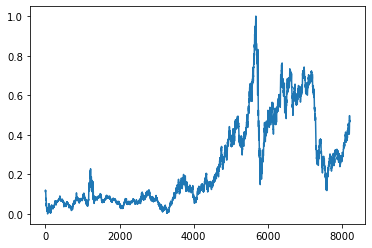

In [15]:
plt.plot(data_oil)

# SPLITTING DATA INTO TRAINING AND TEST

In [16]:
training_size=int(len(data_oil)*0.65)
test_size=len(data_oil)-training_size
train_data,test_data=data_oil[0:training_size,:],data_oil[training_size:len(data_oil),:1]

In [17]:
training_size,test_size

(5340, 2876)

In [18]:
train_data.shape

(5340, 1)

# CREATING THE DATASET

In [19]:
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [20]:
time_step=10
x_train,y_train=create_dataset(train_data,time_step)
x_test,y_test=create_dataset(test_data,time_step)

In [21]:
print(x_train.shape),print(y_train.shape)

(5329, 10)
(5329,)


(None, None)

In [22]:
print(x_test.shape),print(y_test.shape)

(2865, 10)
(2865,)


(None, None)

In [23]:
x_train

array([[0.11335703, 0.11661484, 0.12053902, ..., 0.10980305, 0.1089886 ,
        0.11054346],
       [0.11661484, 0.12053902, 0.11550422, ..., 0.1089886 , 0.11054346,
        0.10165852],
       [0.12053902, 0.11550422, 0.1156523 , ..., 0.11054346, 0.10165852,
        0.09906708],
       ...,
       [0.36731823, 0.35176958, 0.36080261, ..., 0.36391234, 0.37042796,
        0.37042796],
       [0.35176958, 0.36080261, 0.35354657, ..., 0.37042796, 0.37042796,
        0.37879461],
       [0.36080261, 0.35354657, 0.35295424, ..., 0.37042796, 0.37879461,
        0.37916482]])

In [24]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

# IMPORTING THE MODEL BUILDING LIBRARIES

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [28]:
pip install tensorflow


     ------------------------------------ 455.9/455.9 MB 554.0 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 2.2 MB/s eta 0:00:00
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
     ------------------------------------ 895.9/895.9 kB 644.1 kB/s eta 0:00:00
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
     ---------------------------------------- 3.7/3.7 MB 659.2 kB/s eta 0:00:00
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached

# INITIALIZING THE MODEL

In [26]:
model=Sequential()

# ADDING LSTM LAYERS

In [27]:
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))

# ADDING OUTPUT LAYERS

In [28]:
model.add(Dense(1))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


# CONFIGURING THE LEARNING PROCESS

In [30]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3,batch_size=64,verbose=1)

Epoch 1/3
84/84 [==============================] - 6s 27ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 2/3
84/84 [==============================] - 2s 18ms/step - loss: 1.3539e-04 - val_loss: 8.6572e-04
Epoch 3/3
84/84 [==============================] - 2s 18ms/step - loss: 1.2308e-04 - val_loss: 7.8294e-04


# MODEL EVALUATION

In [32]:
train_predict=scaler.inverse_transform(train_data) 
test_predict=scaler.inverse_transform(test_data)
### Calculate RMSE performance metrics
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(train_data,train_predict))

29.347830443269938

# SAVING THE MODEL

In [33]:
from tensorflow.keras.models import load_model

In [34]:
model.save("crude_oil.h5")

In [55]:
!tar -zcvf crudeoils.tgz crude_oil.h5

crude_oil.h5


# TESTING THE MODEL

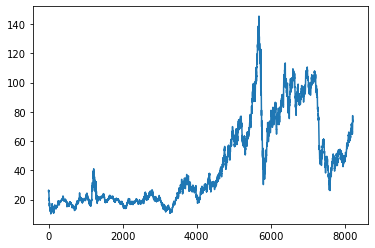

In [35]:
look_back=10
trainpredictPlot = np.empty_like(data_oil)
trainpredictPlot[:, :]= np.nan
trainpredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictplot = np.empty_like(data_oil)
testPredictplot[:,: ] = np.nan
testPredictplot[look_back:len(test_predict)+look_back, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_oil))
plt.show()

In [36]:
x_input=test_data[2866:].reshape(1,-1)
x_input.shape

(1, 10)

In [37]:
temp_input=list(x_input) 
temp_input=temp_input[0].tolist()

In [38]:
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [39]:
lst_output=[]
n_steps=10
i=0
while(i<10):
    if(len(temp_input)>10):
#print(temp_input)
       x_input=np.array(temp_input[1:]) 
       print("{} day input {}".format(i,x_input))
       x_input=x_input.reshape(1,-1)
       x_input = x_input.reshape((1, n_steps, 1)) #print(x_input)
       yhat = model.predict(x_input, verbose=0)
       print("{} day output {}".format(i,yhat))
       temp_input.extend(yhat[0].tolist())
       temp_input=temp_input[1:] #print(temp_input)
       lst_output.extend(yhat.tolist())
       i=i+1
    else:
       x_input = x_input.reshape((1, n_steps,1))
       yhat = model.predict(x_input, verbose=0)
       print(yhat[0])
       temp_input.extend(yhat[0].tolist()) 
       print(len(temp_input))
       lst_output.extend(yhat.tolist())
       i=i+1

[0.47629482]
11
1 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.47629482]
1 day output [[0.47972137]]
2 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.47629482 0.47972137]
2 day output [[0.4785291]]
3 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.47629482 0.47972137 0.4785291 ]
3 day output [[0.4757732]]
4 day input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.47629482 0.47972137 0.4785291  0.47577319]
4 day output [[0.47672924]]
5 day input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.47629482
 0.47972137 0.4785291  0.47577319 0.47672924]
5 day output [[0.47719878]]
6 day input [0.47341922 0.46497853 0.47038353 0.47149415 0.47629482 0.47972137
 0.4785291  0.47577319 0.47672924 0.47719878]
6 day output [[0.47796747]]
7 day input [0.46497853 0.47038353 0.47149415 0.47629482 0.47972137 

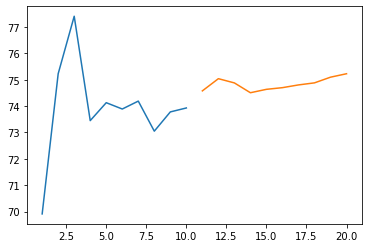

In [40]:
day_new=np.arange(1,11) 
day_pred=np.arange(11,21)
len(data_oil)
plt.plot(day_new, scaler.inverse_transform(data_oil[8206:])) 
plt.plot(day_pred, scaler.inverse_transform(lst_output))

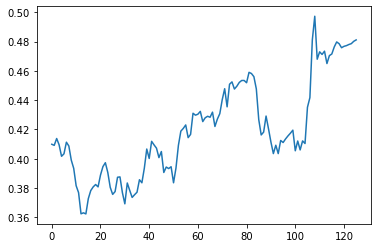

In [41]:
df3=data_oil.tolist() 
df3.extend(lst_output) 
plt.plot(df3[8100:])

In [42]:
df3=scaler.inverse_transform(df3).tolist()

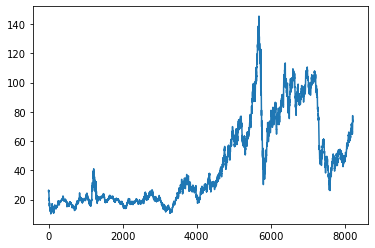

In [43]:
plt.plot(scaler.inverse_transform(data_oil))

In [44]:
!pip install watson-machine-learning-client

     |████████████████████████████████| 538 kB 23.0 MB/s eta 0:00:01


In [45]:
!pip install ibm_watson_machine_learning

In [47]:
from ibm_watson_machine_learning import APIClient
wml_credentials ={
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"Rg0cfF6TtFNPcwNKGgF_2IN9wC5hvgnfHA0ZmzykQ2cK"
}
client = APIClient(wml_credentials)
client

In [48]:
def guid_space_name(client,B2_deploy):
  space = client.spaces.get_details()
  return(next(item for item in space['resources'] if item['entity']['name']==B2_deploy)['metadata']['id'])

In [49]:
space_uid = guid_space_name(client,'models')
space_uid

'8d00d49d-dbc7-4894-9e53-5dc418d65dac'

In [50]:
client.set.default_space(space_uid)

'SUCCESS'

In [51]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [52]:
software_space_uid = client.software_specifications.get_uid_by_name('tensorflow_rt22.1-py3.9')
software_space_uid

'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [56]:
model_details = client.repository.store_model(model='crudeoils.tgz',meta_props={
    client.repository.ModelMetaNames.NAME:"Crude_Oil_Prediction",
    client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
})

In [57]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'software_spec': {'id': 'acd9c798-6974-5d2f-a657-ce06e986df4d',
   'name': 'tensorflow_rt22.1-py3.9'},
  'type': 'tensorflow_2.7'},
 'metadata': {'created_at': '2022-11-15T17:49:11.301Z',
  'id': '31a101fd-b477-4661-946e-97e4028ef61a',
  'modified_at': '2022-11-15T17:49:16.464Z',
  'name': 'Crude_Oil_Prediction',
  'owner': 'IBMid-6640045072',
  'resource_key': 'e6ce26e0-f4ad-4aa5-9d68-8cc7bab6a48e',
  'space_id': '8d00d49d-dbc7-4894-9e53-5dc418d65dac'},
 'system': {'warnings': []}}